In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import torch
from torch.nn import MSELoss
from torch.distributions import Categorical
import tqdm


from gflownet_playground.gfn_models import PF, UniformPB
from gflownet_playground.envs.hypergrid.hypergrid_env import HyperGrid
from gflownet_playground.replay_buffer import ReplayBuffer

import matplotlib.pyplot as plt

from gflownet_playground.envs.hypergrid.utils import KHotPreprocessor, OneHotPreprocessor, get_states_indices
from gflownet_playground.losses import trajectory_balance_loss, online_TB_loss

from gflownet_playground.utils import sample_trajectories, uniform_sample_trajectories


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
ndim = 2
H = 64

env = HyperGrid(ndim=ndim, H=H, R0=0.1)


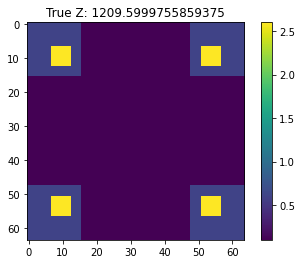

In [5]:
all_rewards = env.reward(env.grid)
true_Z = all_rewards.sum().item()
if ndim == 2:
    plt.imshow(all_rewards)
    plt.title('True Z: {}'.format(true_Z))
    plt.colorbar()
    plt.show()

In [6]:
true_dist = all_rewards.flatten() / all_rewards.sum()
print('True distribution: {}'.format(true_dist))

True distribution: tensor([0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005])


In [45]:
# Get validation trajectories
start_states = torch.zeros((30, ndim)).float()
val_trajectories, val_actionss, val_rewards = uniform_sample_trajectories(env, start_states)

In [46]:
# GLOBAL PARAMS
USE_BUFFER = False
USE_TRUE_Z = False

LR = 1e-3
LR_Z = 0.1

In [47]:
preprocessor = KHotPreprocessor(ndim=ndim, H=H)
pf = PF(input_dim=preprocessor.output_dim,
        n_actions=ndim + 1, h=256, preprocessor=preprocessor).to(device)
pb = UniformPB(n_actions=ndim +1)

optimizer = torch.optim.Adam([{'params': pf.parameters(), 'lr': LR}])
temperature = 1.

if USE_BUFFER:
        capacity = 20000
        max_length = 100
        buffer = ReplayBuffer(capacity=capacity, max_length=max_length, state_dim=ndim)

if USE_TRUE_Z:
        logZ = torch.log(torch.tensor(true_Z)).to(device)
else:
        logZ = torch.zeros((1, )).to(device)
        logZ.requires_grad_(True)
        optimizer.add_param_group({'params': [logZ], 'lr': LR_Z})



In [48]:
batch_size = 128
n_iters = 5000
start_states = torch.zeros((batch_size, ndim))
loss_fn = MSELoss()
losses_TB = []

validation_losses = []

all_terminating_states_visited = []
unique_seen_reward_sum = 0
terminal_states_counter = torch.zeros_like(true_dist)

def validate(env, pf, pb, logZ, val_trajs, val_actionss, val_rewards):
    loss = 0
    for traj, actions, reward in zip(val_trajs, val_actionss, val_rewards):
        loss_traj, _ = trajectory_balance_loss(env, pf, pb, logZ, traj[:-1], actions, reward)
        loss += loss_traj.item()
    return loss / len(val_trajs)



In [49]:
# online Trajecory Balance
print('True Z: {:.2f}'.format(true_Z))
validation_losses.append(validate(env, pf, pb, logZ, val_trajectories, val_actionss, val_rewards))
for i in (pbar := tqdm.trange(n_iters)):
    start_states = torch.zeros((batch_size, ndim))

    if USE_BUFFER:
        rollouts = sample_trajectories(env, pf, start_states, max_length=max_length, temperature=temperature)
        trajs, states, actionss, dones, rewards = rollouts
        buffer.add(trajs, actionss, rewards, dones)
        rewards = rewards[dones]
        trajs, actionss, rewardss = buffer.sample(batch_size)
        loss = torch.zeros(torch.Size([]))
        for traj, actions, reward in zip(trajs, actionss, rewardss):
            traj = traj[:-1][actions != -1]
            actions = actions[actions != -1]
            loss_traj, trajectory_logprob = trajectory_balance_loss(env, pf, pb, logZ, traj, actions,
                                                                    reward)
            loss += loss_traj
        loss /= len(trajs)

    else:
        states, loss, rewards = online_TB_loss(env, pf, pb, logZ, start_states, device=device)

    states_indices = get_states_indices(states, H)
    all_terminating_states_visited.extend(list(states_indices.numpy()))
    unique_states, unique_states_indices = np.unique(
        states_indices, return_index=True)
    unique_seen_reward_sum += rewards[unique_states_indices][
        terminal_states_counter[unique_states] == 0].sum().item()
    terminal_states_counter[states_indices] += 1


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_TB.append(loss.item())

    validation_losses.append(validate(env, pf, pb, logZ, val_trajectories, val_actionss, val_rewards))

    if i % 100 == 0:
        empirical_dist = terminal_states_counter / terminal_states_counter.sum()
        l1 = np.abs(empirical_dist - true_dist).mean()
    summary_string = 'Z: {:.2f}, seen rewards sum: {:.2f}'.format(torch.exp(logZ).item(), unique_seen_reward_sum)
    summary_string += ', current_batch_loss: {:.2f}, '.format(loss.item())
    summary_string += 'n_traj: {}, L1 error so far: {:.6f}'.format(len(all_terminating_states_visited), l1)
    summary_string += ', validation loss: {:.6f}'.format(validation_losses[-1])
    pbar.set_description(summary_string)


True Z: 1209.60


Z: 6474.50, seen rewards sum: 1209.20, current_batch_loss: 0.14, n_traj: 55296, L1 error so far: 0.000201, validation loss: 2.186432:   9%|▊         | 432/5000 [02:07<22:27,  3.39it/s]


KeyboardInterrupt: 

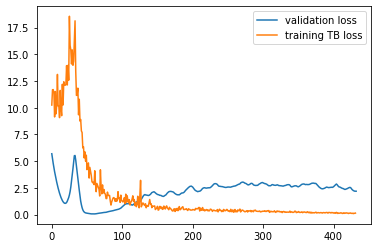

In [51]:
plt.plot(validation_losses, label='validation loss')
plt.plot(losses_TB, label='training TB loss')
plt.legend()
plt.show()

In [80]:
start_states = torch.zeros((1000, ndim))

trajs, last_states, actionss, dones, rewards = sample_trajectories(env, pf, start_states,
                                            max_length=max_length, temperature=1.)

empirical_dist = torch.zeros((H, ) * ndim).long()
for state in last_states:
    empirical_dist[tuple(state.long().numpy())] += 1

empirical_dist = empirical_dist / empirical_dist.sum()


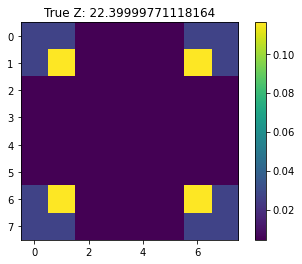

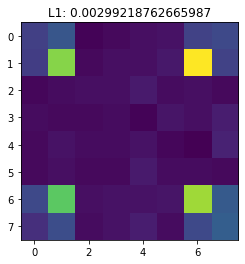

In [81]:
true_dist = all_rewards / all_rewards.sum()
l = np.abs(true_dist - empirical_dist).mean()
if ndim == 2:
    plt.imshow(true_dist)
    plt.title('True Z: {}'.format(true_Z))
    plt.colorbar()
    plt.show()

    plt.imshow(empirical_dist)
    plt.title('L1: {}'.format(l))

In [10]:
a = torch.randint(0, 2, (1, 4)).bool()
a

tensor([[ True, False,  True, False]])

In [20]:
np.random.choice([i for i, j in enumerate(a[0]) if not j ])

3